In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn
import cv2 as cv
import nibabel as nib
import pickle
import glob
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm
import gc, os
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Multiply, UpSampling2D
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure
#import keras_segmentation as ks

warnings.filterwarnings('ignore')
%matplotlib inline
print("Version: ", tf.version.VERSION)
physical_devices = tf.config.list_physical_devices()
print(physical_devices)

Version:  2.2.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


# 1. Defining evaluation metrics


In [2]:
def dice(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred): #Binary Cross-Entropy
    loss = 0.5*losses.binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

def tversky_loss(y_true, y_pred):
    alpha, beta  = 0.5, 0.5
    ones = K.ones(K.shape(y_true))
    p0 = y_pred
    p1 = ones-y_pred
    g0 = y_true
    g1 = ones-y_true
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    T = K.sum(num/den) 
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + 
                     K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1*m2)
    score = (2.*K.sum(w*intersection) + smooth) / (K.sum(w*m1) + K.sum(w*m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    averaged_mask = K.pool2d(y_true, pool_size=(50, 50), strides=(1, 1), 
                             padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5.*K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 0.5*weighted_bce_loss(y_true, y_pred, weight) + 0.5*dice_loss(y_true, y_pred)
    return loss

# 2. Cosine Annealing Learning Rate


In [3]:
# define custom learning rate schedule
class CosineAnnealingLearningRateSchedule(callbacks.Callback):
    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()
 
    # calculate learning rate for an epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = np.floor(n_epochs/n_cycles)
        cos_inner = (np.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (np.cos(cos_inner) + 1)
 
    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs=None):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        # set learning rate
        K.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)

# 3. Convolutional Neural Networks

## 3.1. Lung Segmentation

In [5]:
img_size = 128

In [8]:
def lung_seg(input_shape, num_filters=[16,32,128]) :
    
    x_input = Input(input_shape)
    
    ###  LUNG SEGMENTATION
    x = Conv2D(num_filters[0], kernel_size=3, activation='relu', padding='same')(x_input)
    x = MaxPooling2D(pool_size=2, padding='same')(x)

    x = Conv2D(num_filters[1], kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)

    x = Conv2D(num_filters[2], kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)

    x = Dense(num_filters[2], activation='relu')(x)

    x = UpSampling2D(size=2)(x)
    x = Conv2D(num_filters[2], kernel_size=3, activation='sigmoid', padding='same')(x)

    x = UpSampling2D(size=2)(x)
    x = Conv2D(num_filters[1], kernel_size=3, activation='sigmoid', padding='same')(x)

    x = UpSampling2D(size=2)(x)
    lung_seg = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(x) # identifying lungs

    model = Model(inputs=x_input, outputs=lung_seg, name='lung_seg')
    
    return model

with tf.device('/cpu:0') :
    lung_seg = lung_seg([img_size, img_size, 1])
    lung_seg.summary()
    lung_seg.load_weights("../outputs/weights_lungseg.hdf5")

Model: "lung_seg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       36992     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0  

## 3.2. Infection Segmentation

In [9]:
def downsampling_block_1 (x_in, conv2Dfilters, maxpool2Dsize=(2,2), trainable=True) :
    x = Conv2D(conv2Dfilters, (3,3), activation='relu', padding='same', 
               kernel_initializer="he_normal", trainable=trainable) (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal", trainable=trainable) (x)
    x_inter = BatchNormalization(trainable=trainable) (x)
    x = MaxPooling2D(maxpool2Dsize) (x_inter) 
    x = Dropout(0.2)(x) 
    
    return x, x_inter

def downsampling_block_2 (x_in, conv2Dfilters, trainable=True) :
    x = BatchNormalization(trainable=trainable) (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal", trainable=trainable) (x)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal", trainable=trainable) (x) 
    
    return x

In [10]:
## Note: dimensions are listed for a 100x100 input images
def single_stage_seg(x_input, num_filters, trainable=True) :
    
    x, x1 = downsampling_block_1 (x_input, num_filters[0], maxpool2Dsize=(2,2), trainable=trainable) #x: 50x50
    x, x2 = downsampling_block_1 (x, num_filters[1], maxpool2Dsize=(2,2), trainable=trainable) #x: 25x25
    x, _ = downsampling_block_1 (x, num_filters[2], maxpool2Dsize=(1,1), trainable=trainable) #x: 25x25
    x, _ = downsampling_block_1 (x, num_filters[3], maxpool2Dsize=(1,1), trainable=trainable) #x: 25x25

    x = downsampling_block_2 (x, num_filters[3], trainable=trainable) #x: 25x25
    
    x = Conv2DTranspose(num_filters[2], (2, 2), strides=(2,2), padding='same', trainable=trainable) (x) #x: 50x50
    x = downsampling_block_2 (x, num_filters[2], trainable=trainable) #x: 50x50

    x = Conv2DTranspose(num_filters[1], (2, 2), padding='same', trainable=trainable) (x) #x: 50x50
    x = concatenate([x, x2]) #x: 50x50
    x = downsampling_block_2 (x, num_filters[1], trainable=trainable) #x: 50x50

    x = Conv2DTranspose(num_filters[0], (2, 2), strides=(2,2), padding='same', trainable=trainable) (x) #x: 100x100
    x = concatenate([x, x1], axis=3) #x: 100x100
    x = downsampling_block_2 (x, num_filters[0], trainable=trainable) #x: 100x100
    
    return x

In [12]:
def infect_seg(input_shape, num_filters=[32,64,64,128]) :
    
    x_input = Input(input_shape)
    
    ###  INFECTION SEGMENTATION
    x = single_stage_seg(x_input, num_filters, trainable=True)
    
    infect_seg = Conv2D(1, (1, 1), activation='sigmoid', 
                          name='lung_output', trainable=True)(x) # identifying lungs

    model = Model(inputs=x_input, outputs=infect_seg, name='infect_seg')
    
    return model

with tf.device('/cpu:0') :
    infect_seg = infect_seg([img_size, img_size, 1])
    infect_seg.summary()
    infect_seg.load_weights("../outputs/weights_infectseg.hdf5")

Model: "infect_seg"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 128, 128, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_7[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d_8[0][0]                   
_________________________________________________________________________________________

# 4. Helper Function

In [22]:
def crop_(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:miny+maxy, minx:minx+maxx]

def make_lungmask_bbox(image, bimage):
    height, width = bimage.shape
    _, thresh = cv.threshold(bimage.astype('uint8'), 0.5, 1, 0)
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    img_cnt = cv.drawContours(bimage, contours, -1, (0,255,0), 3)
        
    x0, y0, w0, h0 = cv.boundingRect(contours[0])
    x1, y1, w1, h1 = cv.boundingRect(contours[1])

    B = [min(x0,x1)-round(0.05*width), 
         min(y0,y1)-round(0.05*height), 
         max(x0+w0,x1+w1)-min(x0,x1)+round(0.1*width), 
         max(y0+h0,y1+h1)-min(y0,y1)+round(0.1*height)]
    B = [max(B[0],0), max(B[1],0), min(B[2], width), min(B[3], height)]
        
    return B

## 5. Loading data

In [40]:
datadir = '../testing-dir/'

glob_search = os.path.join(datadir, 'patient*')
test_files = sorted(glob.glob(glob_search))

print('num of train patients {}'.format(len(test_files)))

num of train patients 6


In [41]:
cts_all = []
lungs_all = []
infects_all = []

def load_images_helper (glob_search) :
    file = glob.glob(glob_search)
    data = nib.load(file[0])
    data = data.get_fdata()

    height, width, slices = data.shape
    sel_slices = range(round(slices*0.2), round(slices*0.8))

    data = np.rot90(np.array(data))
    data = np.reshape(np.rollaxis(data, 2),(slices,height,width))
    data = data[sel_slices, :, :]
    
    return data
    
    
for fnum in tqdm.tqdm(range(len(test_files))) :
    glob_search = os.path.join(test_files[fnum], '*ctscan*.nii')
    data_cts = load_images_helper(glob_search)

    glob_search = os.path.join(test_files[fnum], '*lung*.nii')
    data_lungs = load_images_helper(glob_search)

    glob_search = os.path.join(test_files[fnum], '*infection*.nii')
    data_infects = load_images_helper(glob_search)

    height, width, slices = data_cts.shape

    for ii in range(data_cts.shape[0]):
        img = cv.resize(data_cts[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
        img = np.reshape(img, (img_size, img_size, 1))
        cts_all.append(img)
        
        img = cv.resize(data_lungs[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
        img = np.reshape(img, (img_size, img_size, 1))
        lungs_all.append(img)

        img = cv.resize(data_infects[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
        img = np.reshape(img, (img_size, img_size, 1))
        infects_all.append(img)
        
print(len(cts_all))

100%|██████████| 6/6 [00:00<00:00, 12.66it/s]

85


In [42]:
cts = tf.convert_to_tensor(cts_all)
lungs = tf.convert_to_tensor(np.asarray(lungs_all))
infects = tf.convert_to_tensor(np.asarray(infects_all))

print(cts.shape, lungs.shape, infects.shape)

(85, 128, 128, 1) (85, 128, 128, 1) (85, 128, 128, 1)


# 6. Lung Segmentation

In [43]:
with tf.device('/cpu:0') :
    pred_lungs = lung_seg.predict(cts/255, batch_size=512)
    pred_lungs = tf.cast(pred_lungs+0.5, dtype=tf.int32)
    
print(cts.shape, pred_lungs.shape)

(85, 128, 128, 1) (85, 128, 128, 1)


In [44]:
ccts = []
cpred_lungs = []
clungs = []
cinfects = []
bad_ids = []

with tf.device('/cpu:0') :
    for ii in range(len(cts)) :
        try :
            ct_img = np.asarray(cts[ii, :, :, 0])
            pred_lung_img = np.asarray(pred_lungs[ii, :, :, 0])
            lung_img = np.asarray(lungs[ii, :, :, 0])
            infect_img = np.asarray(infects[ii, :, :, 0])

            bounds = make_lungmask_bbox(ct_img, pred_lung_img)

            img = crop_(ct_img, bounds)
            img = cv.resize(img, dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
            img = np.reshape(img, (img_size, img_size, 1))
            ccts.append(img)

            img = crop_(pred_lung_img.astype('float32'), bounds)
            img = cv.resize(img, dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
            img = np.reshape(img, (img_size, img_size, 1))
            cpred_lungs.append(img)

            img = crop_(lung_img.astype('float32'), bounds)
            img = cv.resize(img, dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
            img = np.reshape(img, (img_size, img_size, 1))
            clungs.append(img)

            cinfect_img = crop_(infect_img.astype('float32'), bounds)
            img = cv.resize(cinfect_img, dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
            img = np.reshape(img, (img_size, img_size, 1))
            cinfects.append(img)
        except :
            bad_ids.append(ii)
 
ccts = tf.convert_to_tensor(ccts)
cpred_lungs = tf.convert_to_tensor(np.asarray(cpred_lungs))
clungs = tf.convert_to_tensor(np.asarray(clungs))
cinfects = tf.convert_to_tensor(np.asarray(cinfects))
    
print(ccts.shape, cpred_lungs.shape, clungs.shape, cinfects.shape, len(bad_ids))

(81, 128, 128, 1) (81, 128, 128, 1) (81, 128, 128, 1) (81, 128, 128, 1) 4


# 7. Infection Segmentation

In [45]:
with tf.device('/cpu:0') :
    pred_infects = infect_seg.predict(ccts/255, batch_size=128)
    pred_infects = tf.cast(pred_infects+0.5, dtype=tf.int32)
    
print(ccts.shape, clungs.shape, pred_infects.shape, cinfects.shape)

(81, 128, 128, 1) (81, 128, 128, 1) (81, 128, 128, 1) (81, 128, 128, 1)


In [66]:
def dice(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice(y_true, y_pred)
    return loss

lung_loss = dice_loss(clungs, cpred_lungs)
lung_dice = dice(clungs, cpred_lungs)
infect_loss = dice_loss(cinfects, tf.cast(pred_infects, dtype=tf.float32))
infect_dice = dice(cinfects, tf.cast(pred_infects, dtype=tf.float32))

print('*'*20 + ' TEST RESULTS ' + '*'*20)
print("\n\t\t\tloss\t\tdice coeff\n\t Lung:\t\t{:0.4f}\t\t{:0.4f}\n".format(
                lung_loss, lung_dice),
                  "\t Infection:\t{:0.4f}\t\t{:0.4f}".format(infect_loss, infect_dice))

******************** TEST RESULTS ********************

			loss		dice coeff
	 Lung:		0.0590		0.9410
 	 Infection:	0.4809		0.5191


# 8. Visualize predicted outputs

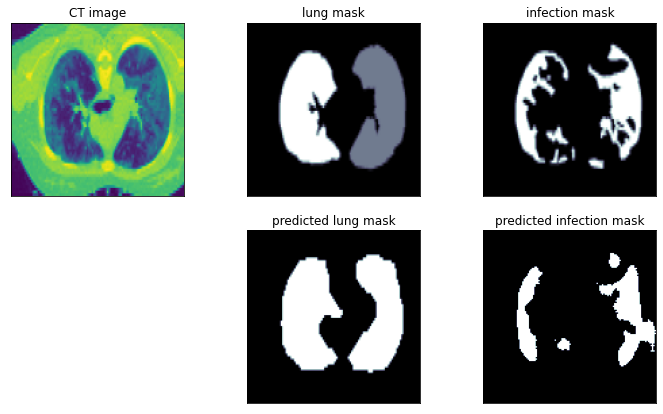

In [56]:
def compare_actual_and_predicted(img_num):

    fig = plt.figure(figsize=(12,7))

    plt.subplot(2,3,1)
    plt.imshow(tf.reshape(ccts[img_num], [img_size, img_size]))
    plt.title('CT image'); plt.grid(None)
    plt.xticks([]); plt.yticks([])
    
    plt.subplot(2,3,2)
    plt.imshow(tf.reshape(clungs[img_num], [img_size, img_size]), cmap='bone')
    plt.title('lung mask'); plt.grid(None)
    plt.xticks([]); plt.yticks([])

    plt.subplot(2,3,3)
    plt.imshow(tf.reshape(cinfects[img_num], [img_size, img_size]), cmap='bone')
    plt.title('infection mask'); plt.grid(None)
    plt.xticks([]); plt.yticks([])

    plt.subplot(2,3,5)
    plt.imshow(tf.reshape(cpred_lungs[img_num], [img_size, img_size]), cmap='bone')
    plt.title('predicted lung mask'); plt.grid(None)
    plt.xticks([]); plt.yticks([])

    plt.subplot(2,3,6)
    plt.imshow(tf.reshape(pred_infects[img_num], [img_size, img_size]), cmap='bone')
    plt.title('predicted infection mask'); plt.grid(None)
    plt.xticks([]); plt.yticks([])


compare_actual_and_predicted(40)